# Street racing analysis

By [Ben Welsh](http://palewi.re/who-is-ben-welsh/)

This analysis of street racing fatalities in Los Angeles County was conducted for the March 16, 2018, _Los Angeles Times_ story ["Out of Control: The deadly toll of Los Angeles street racing."](http://www.latimes.com/projects/la-me-street-racing/)

From 2000 to 2017, at least 179 people in Los Angeles County have died in crashes where street racing was suspected, according to a database of coroner’s records, police reports and media accounts compiled by Los Angeles Times reporters James Queally and Nicole Santa Cruz. 

The deadliest year on record during that span was 2007, with 18 fatal crashes. The dead are overwhelmingly male and young: More than half are 21 or younger, including a 4-year-old girl killed with her mother and 8-year-old brother. Slightly less than half of the victims— 47% — were pushing the accelerator. The rest were either passengers in the speeding vehicles, spectators or people simply walking on a sidewalk or driving home.

Deaths have occurred in all areas of Los Angeles County, but some places — Long Beach, Santa Clarita, industrial zones Southeast of downtown and the wide boulevards that stretch across South L.A. and the San Fernando Valley — have become hotbeds of fatal activity.

In the past three years, seven people have died on the streets of Commerce, a city of about 13,000 traversed by the 5 and 710 freeways. Three of those deaths — including two teenagers on their way home from Disneyland — occurred in a fiery 2016 crash set off when a suspected street racer driving more than 100 mph lost control on the 5.

The data and computer code that generated those conclusions is below.

## Preparation

Import third-party libraries

In [1]:
import geopandas as gpd

Import custom libraries

In [24]:
from src import maps
from src import charts
from src import geocoder
from src import transform
from src import calculate

Configure the notebook

In [3]:
%matplotlib inline

Import source data

In [4]:
fatalities = gpd.pd.read_csv("./input/street-racing-fatalities.csv")

Put our events on the map using a geocoder.

In [5]:
fatalities = fatalities.apply(geocoder.geocode, axis=1)

Analyze how many have been mapped.

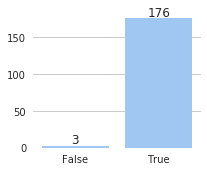

In [6]:
charts.bar(fatalities.is_mapped.value_counts(), figwidth=3, figheight=2.5)

Trim and clean the columns

In [8]:
fatalities = fatalities.rename(columns=transform.columns)[list(transform.columns.values())]

Convert it into a GeoDataFrame for mapping.

In [9]:
fatalities = transform.df_to_gdf(fatalities)

## Analysis

What is the total number of fatalities?

In [10]:
len(fatalities)

179

What has the trend been over time?

In [11]:
fatalities['death_year'] = fatalities.death_datetime.apply(lambda x: gpd.pd.to_datetime(x).year)

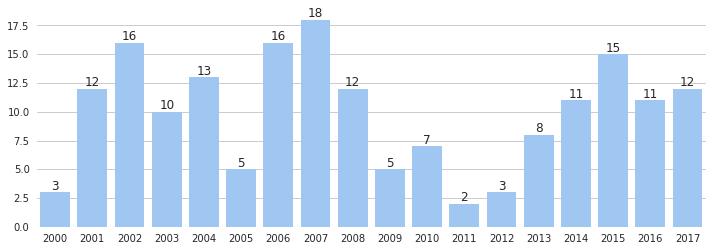

In [12]:
charts.bar(fatalities.death_year.value_counts(), figwidth=12)

Who are the victims?

In [13]:
fatalities.age.describe().to_frame()

,age
count,179.000000
mean,25.871508
std,12.732345
min,4.000000
25%,19.000000
50%,21.000000
75%,27.500000
max,81.000000


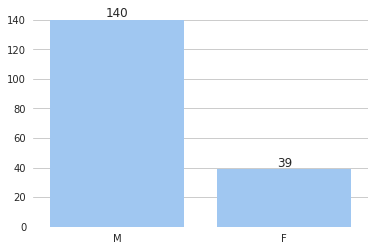

In [14]:
charts.bar(fatalities.gender.value_counts())

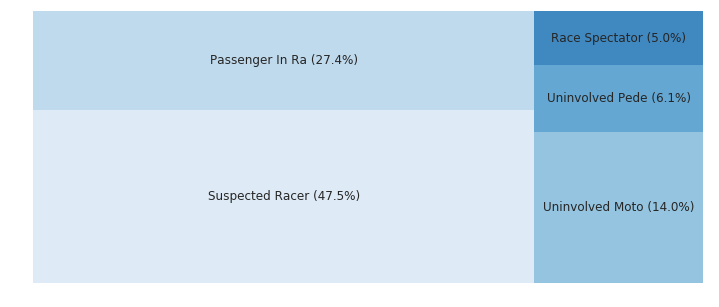

In [15]:
charts.tree(fatalities.victim_role.value_counts(normalize=True))

Where do they happen?

In [16]:
points = transform.groupby_point(fatalities)

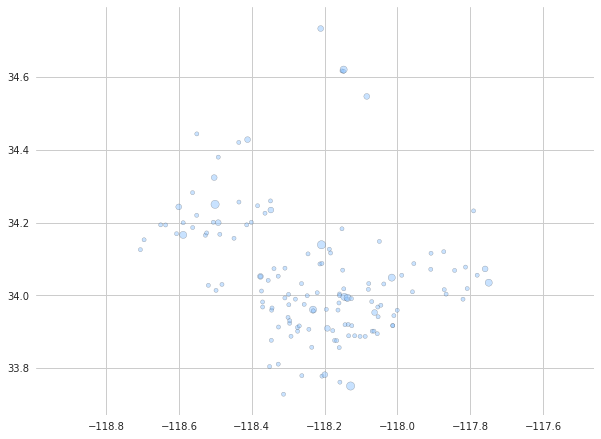

In [17]:
maps.circles(points)

### What neighborhoods have the most?

Merge the fatalities to the Los Angeles Times neighborhood definitions.

In [18]:
hoods = gpd.read_file("./input/hoods.shp")

Group and count by neighborhood

In [19]:
fatalities_with_hoods = gpd.sjoin(hoods, fatalities, how="inner")

In [20]:
hood_counts = fatalities_with_hoods.groupby("name").size().reset_index()

In [21]:
hood_counts.columns = ["name", "total"]

Look at the gross totals.

In [22]:
hood_counts[['name', 'total']].sort_values("total", ascending=False).head(10)

,name,total
13,Commerce,11
38,Long Beach,11
54,Pomona,6
50,Palmdale,6
59,Santa Clarita,5
24,Florence-Firestone,5
47,Norwalk,4
44,North Hills,4
60,Santa Fe Springs,4
20,Eagle Rock,4


Calculate the per-capita rate.

In [30]:
hood_counts_with_pop = gpd.pd.merge(hood_counts, hoods, on="name")

In [31]:
hood_counts_with_pop['per_capita'] = hood_counts_with_pop.apply(
    lambda x: calculate.per_capita(x.total, x.population),
    axis=1
)

Exclude the very small neighborhoods and see the result.

In [26]:
hood_counts_with_pop[hood_counts_with_pop.population > 1000][[
    'name',
    'total',
    'population',
    'per_capita'
]].sort_values("per_capita", ascending=False).head(10)

,name,total,population,per_capita
13,Commerce,11,13017.000000,8.450488
46,Northwest Palmdale,1,3634.035612,2.751762
60,Santa Fe Springs,4,17162.000000,2.330731
63,Shadow Hills,3,13639.821376,2.199442
53,Pico-Robertson,3,19955.525533,1.503343
83,Willowbrook,3,20685.000000,1.450326
4,Athens,1,8320.000000,1.201923
20,Eagle Rock,4,33550.245583,1.192242
16,Cypress Park,1,9383.436395,1.065708
28,Hancock Park,1,10993.024559,0.909668


How many fatalities occured in the Los Angeles city limits?

In [27]:
len(fatalities_with_hoods[
    (fatalities_with_hoods.city == 'los-angeles') |
    # We're adding in this case because it happened on the other
    # side of the street from the city limits and it was investigated
    # by the Los Angeles Police Department.
    (fatalities_with_hoods.case_number == '2007-09388')
])

60

## Output

Export files for graphics and further exploration.

In [28]:
fatalities_with_hoods.to_csv("./output/fatalities.csv", encoding="utf-8", index=False)

In [29]:
points.to_file("./output/points.shp")